In [24]:
from typing import Dict, List, Tuple
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import random
import json

In [25]:
class BayesNode:
    def __init__(self, name: str) -> None:
        self.name = name
        self.parents: List['BayesNode'] = []
        self.children: List['BayesNode'] = []

    def add_parent(self, parent: 'BayesNode') -> None:
        self.parents.append(parent)

    def add_child(self, child: 'BayesNode') -> None:
        self.children.append(child)

    def __repr__(self) -> str:
        return self.name

    def __str__(self) -> str:
        return self.name

    def __hash__(self) -> int:
        return hash(self.name)

    def __eq__(self, other: 'BayesNode') -> bool:
        return self.name == other.name

In [26]:
class BayesNetwork:
    def __init__(self, structure : Dict[str, Tuple[List[str], List[str]]], probabilities) -> None:
        self.nodes: Dict[str, BayesNode] = {}
        self.node_values: Dict[str, int] = {}
        self.counter = {}
        self.probabilities = probabilities
        self.initialize_structure(structure)

    def has_node(self, node_name: str) -> bool:
        return node_name in self.nodes

    def get_node(self, node_name: str) -> BayesNode:
        if self.has_node(node_name):
            return self.nodes[node_name]

    def add_node(self, node_name: str) -> BayesNode:
        if not self.has_node(node_name):
            new_node = BayesNode(node_name)
            self.nodes[node_name] = new_node
        return self.get_node(node_name)

    def add_parent_child_relationship(self, parent_node: BayesNode, child_node: BayesNode) -> None:
        if child_node not in parent_node.children:
            parent_node.add_child(child_node)
            child_node.add_parent(parent_node)

    def initialize_structure(self, structure: Dict[str, Dict[str, List[str]]]) -> None:
        for node_name, relationships in structure.items():
            current_node = self.add_node(node_name)
            for parent in relationships['Parents']:
                parent_node = self.add_node(parent)
                self.add_parent_child_relationship(parent_node, current_node)
            for child in relationships['Children']:
                child_node = self.add_node(child)
                self.add_parent_child_relationship(current_node, child_node)

    def show_structure(self) -> None:
        G = nx.DiGraph()
        for node_name, node in self.nodes.items():
            G.add_node(node_name)
            for child in node.children:
                G.add_edge(node_name, child.name)

        pos = graphviz_layout(G, prog='dot')
        nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=5000, font_size=16, font_weight='bold', edge_color='gray')
        plt.margins(0.1)
        plt.show()

In [27]:
class GibbsSampler:
    def __init__(self, bayes_network : BayesNetwork, domain : List[int]) -> None:
        self.bayes_network = bayes_network
        self.domain = domain

    def run(self, evidences : Dict[str, bool], query_variable : str, iterations: int) -> Dict[str, int]:
        self.initialize_values(evidences, self.domain)
        self.initialize_counters(query_variable, self.domain)
        for _ in range(iterations):
            node = self.generate_not_evidence_node(evidences)
            probabilities = self.calculate_conditional_probabilities(node, self.domain)
            new_value = self.sample(probabilities)
            self.bayes_network.node_values[node.name] = new_value
            self.bayes_network.counter[(query_variable, self.bayes_network.node_values[query_variable])] += 1
        return self.normalize(self.bayes_network.counter, iterations)

    def calculate_conditional_probabilities(self, node : BayesNode, domain) -> Dict[int, float]:
        result = {}
        for value in domain:
            if node.parents:
                handler = [value]
                for parent in sorted(node.parents, key=lambda x: x.name):
                    handler.append(parent.name)
                    handler.append(self.bayes_network.node_values[parent.name])
                result[value] = self.get_nested_value(self.bayes_network.probabilities[node.name], handler)
            else:
                result[value] = self.bayes_network.probabilities[node.name][value]

            for child in sorted(node.children, key=lambda x: x.name):
                handler = [value]
                for parent in sorted(child.parents, key=lambda x: x.name):
                    handler.append(parent.name)
                    handler.append(self.bayes_network.node_values[parent.name])
                result[value] *= self.get_nested_value(self.bayes_network.probabilities[child.name], handler)
        return result

    def normalize(self, counter: Dict[Tuple[str, int], int], iterations: int) -> Dict[str, int]:
        result = {}
        for value, count in counter.items():
            result[value] = count / iterations
        return result

    def sample(self, probabilities: Dict[int, float]) -> int:
        total = sum(probabilities.values())
        rand_val = random.uniform(0, total)
        cumulative = 0
        for value, probability in probabilities.items():
            cumulative += probability
            if rand_val <= cumulative:
                return value
        return value

    def initialize_values(self, evidences: Dict[str, bool], domain : List[str]) -> None:
        for node in self.bayes_network.nodes:
            if node in evidences:
                self.bayes_network.node_values[node] = str(int(evidences[node]))
            else:
                self.bayes_network.node_values[node] = random.choice(domain)

    def generate_not_evidence_node(self, evidences : Dict[str, bool]) -> BayesNode:
        not_evidence_nodes = [node for node in self.bayes_network.nodes.values() if node.name not in evidences]
        node = random.choice(not_evidence_nodes)
        return node

    def initialize_counters(self, query_variable : str, domain : List[int]) -> None:
        for value in domain:
            self.bayes_network.counter[(query_variable, value)] = 0

    def get_nested_value(self, dictionary: dict, keys: list) -> float:
        for key in keys:
            if isinstance(dictionary, dict) and key in dictionary:
                dictionary = dictionary[key]
            else:
                return None
        return float(dictionary)

In [29]:
def read_json_file(file_path: str) -> dict:
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

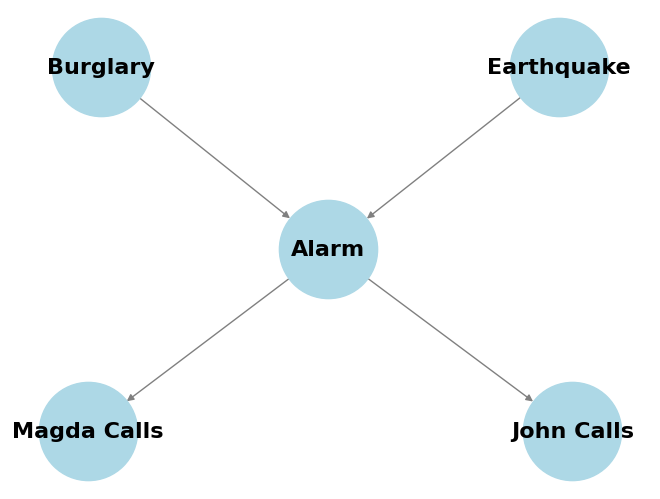

{('John Calls', '0'): 0.1127, ('John Calls', '1'): 0.8873}


In [31]:
evidences = read_json_file("evidences.json")
probabilities = read_json_file("probabilities.json")
structure = read_json_file("bayes_structure.json")

query_variable = "John Calls"
bayes_network = BayesNetwork(structure, probabilities)
bayes_network.show_structure()

gibbs_sampler = GibbsSampler(bayes_network, ['0', '1'])
result = gibbs_sampler.run(evidences, query_variable, 10000)
print(result)